### 1. Visualizing the Raw Dataset for All Files

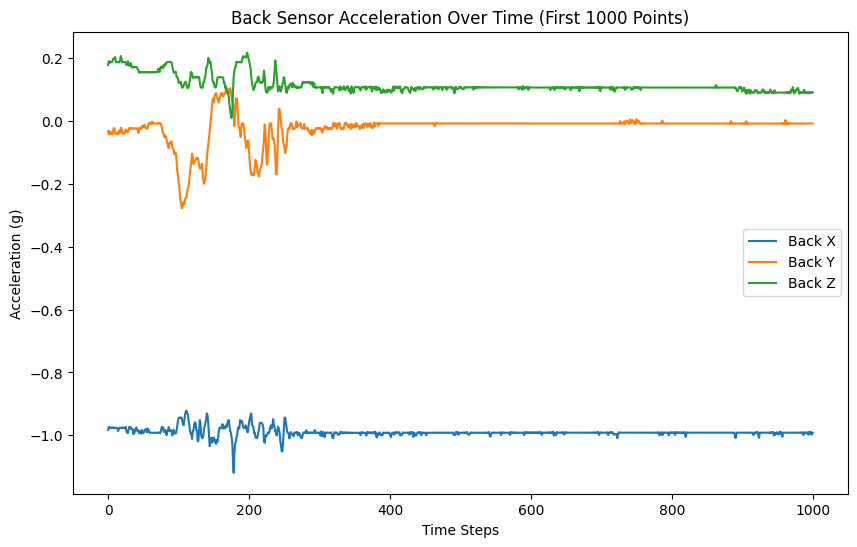

In [15]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# path to the dataset folder and list all CSV files
dataset_folder = 'harth'  # Adjust the path if necessary
files = [f for f in os.listdir(dataset_folder) if f.endswith('.csv')]

# Load all CSV files into a list of DataFrames
dataframes = []
for file in files:
    file_path = os.path.join(dataset_folder, file)
    df = pd.read_csv(file_path)
    dataframes.append(df)

# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

# Preview the combined dataset (first few rows)
combined_df.head()

# Visualize some of the raw data using a line plot for the sensor readings
# Plot the first 1000 points of accelerometer data for back_x, back_y, back_z
plt.figure(figsize=(10, 6))
plt.plot(combined_df['back_x'][:1000], label='Back X')
plt.plot(combined_df['back_y'][:1000], label='Back Y')
plt.plot(combined_df['back_z'][:1000], label='Back Z')
plt.legend()
plt.title('Back Sensor Acceleration Over Time (First 1000 Points)')
plt.xlabel('Time Steps')
plt.ylabel('Acceleration (g)')
plt.show()


### 2. Data Cleansing and Processing for All Files

In [16]:
# Check for missing values and duplicates
missing_data = combined_df.isnull().sum()
print("Missing data per column:\n", missing_data)

# Remove any duplicate rows
combined_df_clean = combined_df.drop_duplicates()

# Check data types and ensure that 'timestamp' is in datetime format
combined_df_clean['timestamp'] = pd.to_datetime(combined_df_clean['timestamp'])

# Re-check the structure of the cleaned dataset
combined_df_clean.info()

# Check for and handle inconsistent values (e.g., acceleration beyond physical limits)
# Assuming valid range for accelerometer data is between -3g and +3g
combined_df_clean = combined_df_clean[
    (combined_df_clean['back_x'].between(-3, 3)) &
    (combined_df_clean['back_y'].between(-3, 3)) &
    (combined_df_clean['back_z'].between(-3, 3)) &
    (combined_df_clean['thigh_x'].between(-3, 3)) &
    (combined_df_clean['thigh_y'].between(-3, 3)) &
    (combined_df_clean['thigh_z'].between(-3, 3))
]


Missing data per column:
 timestamp          0
back_x             0
back_y             0
back_z             0
thigh_x            0
thigh_y            0
thigh_z            0
label              1
index        2387851
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3108490 entries, 0 to 3108489
Data columns (total 9 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   back_x     float64       
 2   back_y     float64       
 3   back_z     float64       
 4   thigh_x    float64       
 5   thigh_y    float64       
 6   thigh_z    float64       
 7   label      float64       
 8   index      float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 213.4 MB


### 3. Data Transformation and Feature Extraction

In [17]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Extract time-based features from the timestamp
combined_df_clean['hour'] = combined_df_clean['timestamp'].dt.hour
combined_df_clean['minute'] = combined_df_clean['timestamp'].dt.minute
combined_df_clean['second'] = combined_df_clean['timestamp'].dt.second

# Feature engineering - Calculate magnitude for back and thigh sensors
combined_df_clean['back_magnitude'] = np.sqrt(
    combined_df_clean['back_x']**2 + combined_df_clean['back_y']**2 + combined_df_clean['back_z']**2
)
combined_df_clean['thigh_magnitude'] = np.sqrt(
    combined_df_clean['thigh_x']**2 + combined_df_clean['thigh_y']**2 + combined_df_clean['thigh_z']**2
)

# Normalize the sensor data using Min-Max scaling
scaler = MinMaxScaler()
combined_df_clean[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']] = scaler.fit_transform(
    combined_df_clean[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']]
)

# Preview the transformed dataset
combined_df_clean.head()


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,index,hour,minute,second,back_magnitude,thigh_magnitude
0,2019-01-12 00:00:00.000,0.381296,0.491754,0.568372,0.344408,0.501055,0.440186,6.0,NaN,0,0,0,0.998742,1.001673
1,2019-01-12 00:00:00.020,0.382955,0.489807,0.570590,0.344435,0.506777,0.438940,6.0,NaN,0,0,0,0.992830,1.005022
2,2019-01-12 00:00:00.040,0.382201,0.491368,0.569683,0.343639,0.504798,0.438318,6.0,NaN,0,0,0,0.995437,1.010420
3,2019-01-12 00:00:00.060,0.382728,0.491203,0.570274,0.343655,0.506039,0.438398,6.0,NaN,0,0,0,0.993351,1.010394
4,2019-01-12 00:00:00.080,0.382311,0.490005,0.569852,0.342574,0.505114,0.439434,6.0,NaN,0,0,0,0.995345,1.013996


### 4. Data Management and Segregation

In [18]:
from sklearn.model_selection import train_test_split

# Define the features (X) and the target variable (y)
X = combined_df_clean.drop(['label', 'timestamp'], axis=1)
y = combined_df_clean['label']

# Perform train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((2463884, 12), (615971, 12), (2463884,), (615971,))

### 5. Basic AI Algorithm

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model using accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Classifier Accuracy: {accuracy * 100:.2f}%")


### 6. Visualizations

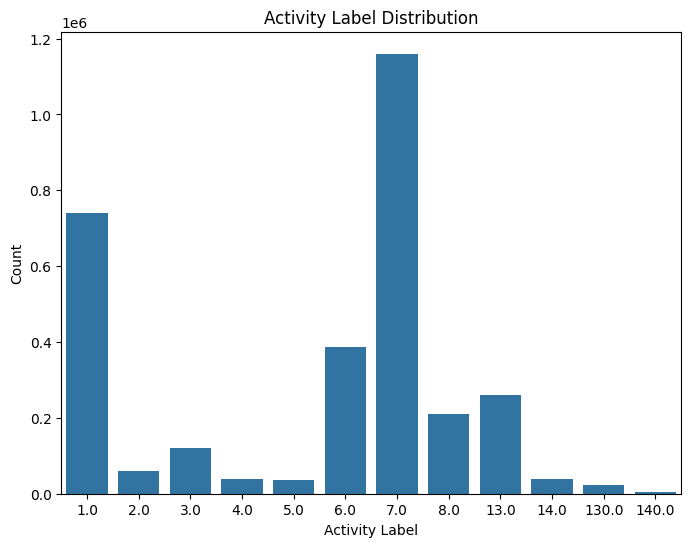

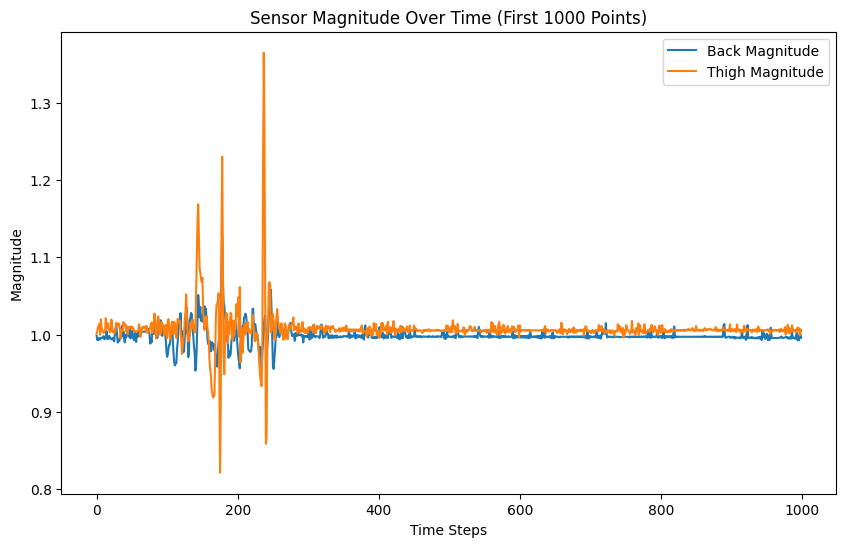

In [19]:
import seaborn as sns

# Visualize the distribution of activity labels
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=combined_df_clean)
plt.title('Activity Label Distribution')
plt.xlabel('Activity Label')
plt.ylabel('Count')
plt.show()

# Plot the sensor data over time
plt.figure(figsize=(10, 6))
plt.plot(combined_df_clean['back_magnitude'][:1000], label='Back Magnitude')
plt.plot(combined_df_clean['thigh_magnitude'][:1000], label='Thigh Magnitude')
plt.legend()
plt.title('Sensor Magnitude Over Time (First 1000 Points)')
plt.xlabel('Time Steps')
plt.ylabel('Magnitude')
plt.show()
